Reference: https://www.youtube.com/watch?v=QpzMWQvxXWk

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('all')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/shalaka/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]

[nltk_data]    |   Package timit is already up-to-date!
[nltk_data]    | Downloading package toolbox to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package toolbox is already up-to-date!
[nltk_data]    | Downloading package treebank to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /home/shalaka/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-da

# 1. Read data 

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
df['Text'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [6]:
df.shape

(568454, 10)

In [7]:
# Down-sampling dataset for now
df = df.head(500)
df.shape

(500, 10)

## 1.1 EDA

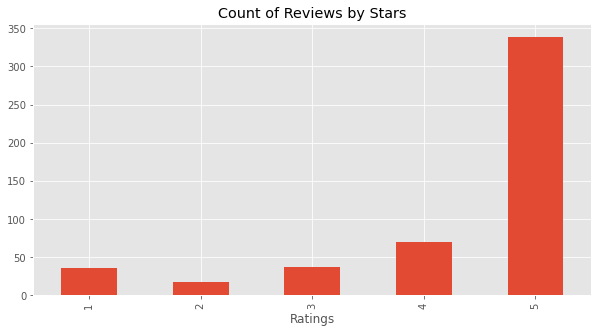

In [8]:
ax = df['Score'].value_counts().sort_index() \
                .plot(kind='bar',
                      title='Count of Reviews by Stars',
                      figsize=(10,5))
ax.set_xlabel('Ratings')
plt.show()

### Using ``nltk``

In [9]:
example = df['Text'][68]
print(example)

If you're impulsive like me, then $6 is ok. Don't get me wrong, the quality of these babies is very good and I have no complaints. But in retrospect, the price is a little ridiculous (esp. when you add on the shipping).


In [10]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['If', 'you', "'re", 'impulsive', 'like', 'me', ',', 'then', '$', '6']

In [11]:
tags = nltk.pos_tag(tokens)
tags[:10]

[('If', 'IN'),
 ('you', 'PRP'),
 ("'re", 'VBP'),
 ('impulsive', 'JJ'),
 ('like', 'IN'),
 ('me', 'PRP'),
 (',', ','),
 ('then', 'RB'),
 ('$', '$'),
 ('6', 'CD')]

In [13]:
entities = nltk.chunk.ne_chunk(tags)
entities.pprint

<bound method Tree.pprint of Tree('S', [('If', 'IN'), ('you', 'PRP'), ("'re", 'VBP'), ('impulsive', 'JJ'), ('like', 'IN'), ('me', 'PRP'), (',', ','), ('then', 'RB'), ('$', '$'), ('6', 'CD'), ('is', 'VBZ'), ('ok.', 'VBN'), ('Do', 'VBP'), ("n't", 'RB'), ('get', 'VB'), ('me', 'PRP'), ('wrong', 'JJ'), (',', ','), ('the', 'DT'), ('quality', 'NN'), ('of', 'IN'), ('these', 'DT'), ('babies', 'NNS'), ('is', 'VBZ'), ('very', 'RB'), ('good', 'JJ'), ('and', 'CC'), ('I', 'PRP'), ('have', 'VBP'), ('no', 'DT'), ('complaints', 'NNS'), ('.', '.'), ('But', 'CC'), ('in', 'IN'), ('retrospect', 'NN'), (',', ','), ('the', 'DT'), ('price', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('little', 'JJ'), ('ridiculous', 'JJ'), ('(', '('), ('esp', 'FW'), ('.', '.'), ('when', 'WRB'), ('you', 'PRP'), ('add', 'VBP'), ('on', 'IN'), ('the', 'DT'), ('shipping', 'NN'), (')', ')'), ('.', '.')])>

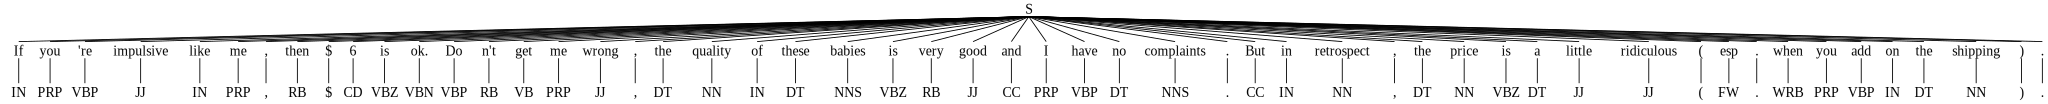

In [14]:
entities

# 2. VADER Sentiment Scoring

- Uses Bag of Words (BoW) approach

In [28]:
analyser = SentimentIntensityAnalyzer()
text_pos = "I'm really happy."
text_neg = "I'm really sad."
text_con = "It's a shame."
example

"If you're impulsive like me, then $6 is ok. Don't get me wrong, the quality of these babies is very good and I have no complaints. But in retrospect, the price is a little ridiculous (esp. when you add on the shipping)."

In [24]:
analyser.polarity_scores(text_pos)

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [23]:
analyser.polarity_scores(text_neg)

{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}

In [26]:
analyser.polarity_scores(text_con)

{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}

In [27]:
analyser.polarity_scores(example)

{'neg': 0.135, 'neu': 0.71, 'pos': 0.155, 'compound': -0.0096}

In [39]:
# Run the dataset through the model
results = {}
for i, data in tqdm(df.iterrows(), total=len(df)):
    text = data['Text']
    text_id = data['Id']
    results[text_id] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
# Convert results dict to a pandas DataFrame
vaders_results = pd.DataFrame(results).T
vaders_results = vaders_results.reset_index().rename(columns={'index': 'Id'})
vaders_results = vaders_results.merge(df, how='left')

In [43]:
# Data with the results from VADERS
vaders_results.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 2.1 Plotting VADER results

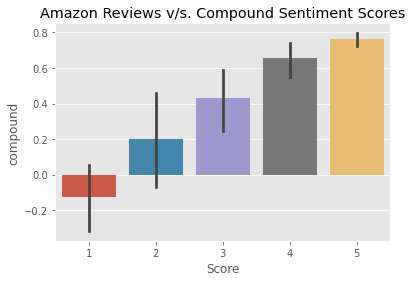

In [47]:
# Assumption: if the score by the customer is 5 stars, 
# then the sentiment is positive, and vice versa

# Option 1
ax = sns.barplot(data=vaders_results, x="Score", y="compound")
ax.set_title("Amazon Reviews v/s. Compound Sentiment Scores")
plt.show()

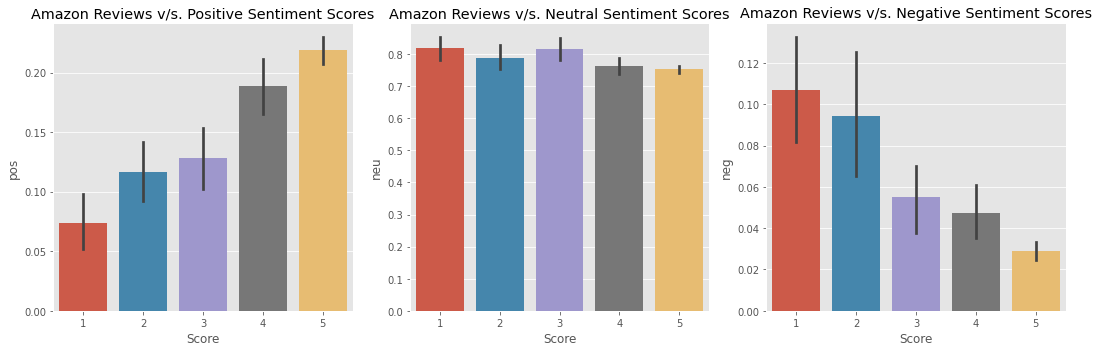

In [56]:
# Option 2
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=vaders_results, x="Score", y="pos", ax=axs[0])
axs[0].set_title("Amazon Reviews v/s. Positive Sentiment Scores")

sns.barplot(data=vaders_results, x="Score", y="neu", ax=axs[1])
axs[1].set_title("Amazon Reviews v/s. Neutral Sentiment Scores")

sns.barplot(data=vaders_results, x="Score", y="neg", ax=axs[2])
axs[2].set_title("Amazon Reviews v/s. Negative Sentiment Scores")

plt.tight_layout()
plt.show()

# 3. Using a Pretrained Model: Roberta

In [65]:
pretrained_model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokeniser = AutoTokenizer.from_pretrained(pretrained_model)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)

In [68]:
# Our OG example
print(example)

# Result on previous example
sia.polarity_scores(example)

If you're impulsive like me, then $6 is ok. Don't get me wrong, the quality of these babies is very good and I have no complaints. But in retrospect, the price is a little ridiculous (esp. when you add on the shipping).


{'neg': 0.135, 'neu': 0.71, 'pos': 0.155, 'compound': -0.0096}

In [70]:
# Result on new model

encoded_text = tokeniser(example, return_tensors="pt")
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0844,  0.1342, -0.1361]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [81]:
berta_scores = output[0][0].detach().numpy()
berta_scores = softmax(berta_scores)
berta_score_dict = {
    'berta_neg': berta_scores[0],
    'berta_neu': berta_scores[1],
    'berta_pos': berta_scores[2]
} 
berta_score_dict

{'berta_neg': 0.35050157, 'berta_neu': 0.36837846, 'berta_pos': 0.2811199}

In [111]:
def polarity_scores_roberta(example): 
    """
    Determine the polarity scores using RoBerta
    """
    encoded_text = tokeniser(example, return_tensors="pt")
    output = model(**encoded_text)
    berta_scores = output[0][0].detach().numpy()
    berta_scores = softmax(berta_scores)
    berta_score_dict = {
        'berta_neg': berta_scores[0],
        'berta_neu': berta_scores[1],
        'berta_pos': berta_scores[2]
    } 
    return berta_score_dict


berta_results = {}
vaders_results = {}
results = {}
for i, data in tqdm(df.iterrows(), total=len(df)):
    try:
        text = data["Text"]
        text_id = data["Id"]

        vaders_results = sia.polarity_scores(text)
        vader_results_final={}

        for key, value in vaders_results.items():
            vader_results_final[f"vader_{key}"] = value

        berta_results = polarity_scores_roberta(text)

        both = {**vader_results_final, **berta_results}

        results[text_id] = both
    except:
        print(f"Broke for id {text_id}")

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [112]:
# Converting to DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,berta_neg,berta_neu,berta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 3.1 Compare scores across both models

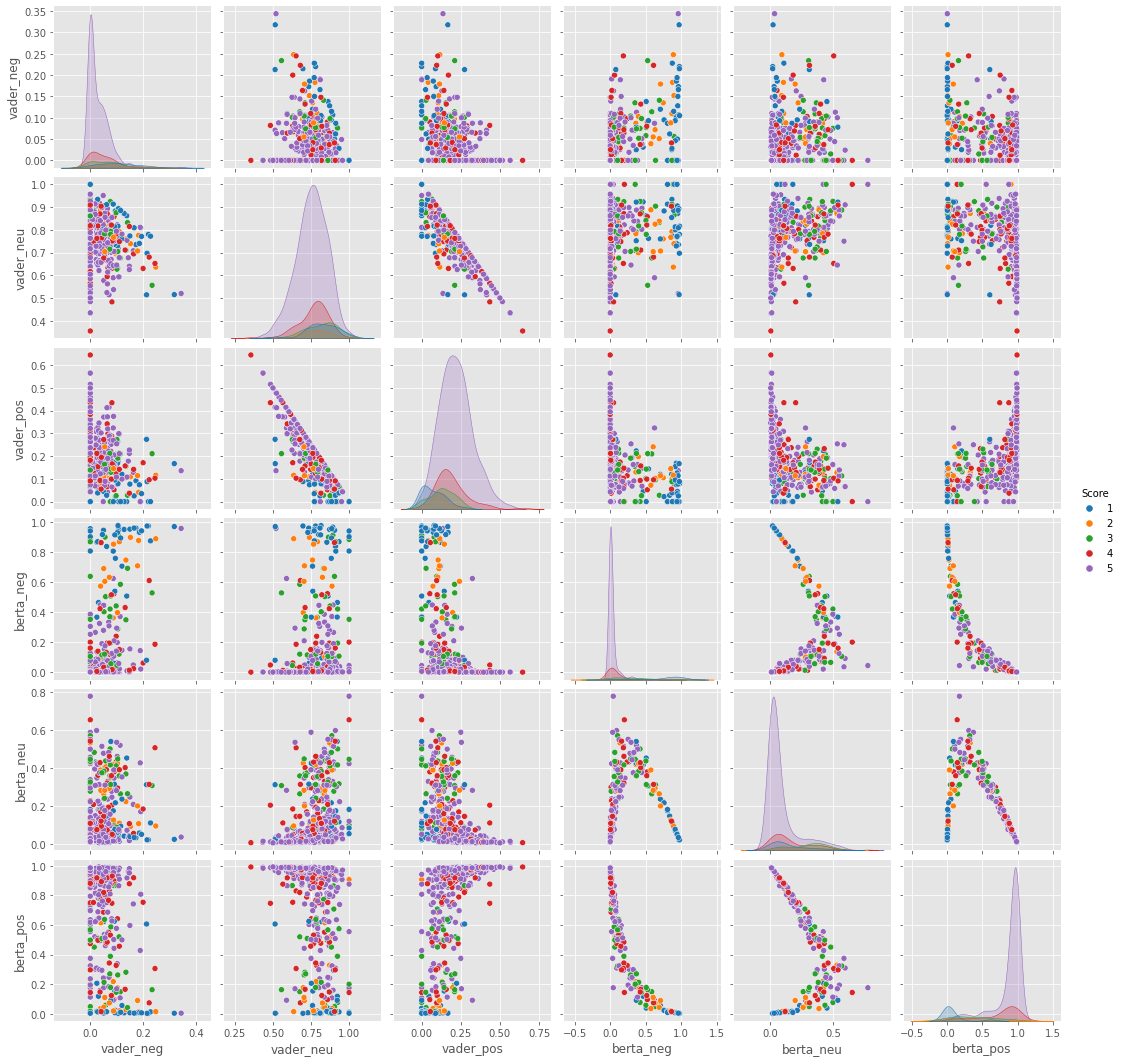

In [113]:
sns.pairplot(data=results_df, 
             vars=["vader_neg", "vader_neu", "vader_pos",
                  "berta_neg", "berta_neu", "berta_pos"],
             hue="Score",
             palette="tab10")

plt.show()

# 4. Review Examples
- Try to understand what the models get wrong/right

In [120]:
# Looking for a example where the ROBERTA model assigns a positive score
# But the customer reviewed with a 1 star
results_df.query("Score==1").sort_values('berta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [121]:
# Looking for a example where the VADER model assigns a positive score
# But the customer reviewed with a 1 star
results_df.query("Score==1").sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [122]:
# Looking for a example where the ROBERTA model assigns a neg score
# But the customer reviewed with a 5 star
results_df.query("Score==5").sort_values('berta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [123]:
# Looking for a example where the VADER model assigns a neg score
# But the customer reviewed with a 5 star
results_df.query("Score==5").sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# 5. Using the Transformer Pipeline

In [126]:
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [127]:
sent_pipeline("This is a happy sentence")

[{'label': 'POSITIVE', 'score': 0.9998641014099121}]

In [128]:
sent_pipeline("This isn't a happy sentence")

[{'label': 'NEGATIVE', 'score': 0.9997770190238953}]

In [129]:
sent_pipeline("Oh no!")

[{'label': 'NEGATIVE', 'score': 0.994263231754303}]

In [136]:
sent_pipeline("It wasn't bad")

[{'label': 'POSITIVE', 'score': 0.9985301494598389}]